# Texture Features
[Image texture](https://en.wikipedia.org/wiki/Image_texture)<br>
[Co-occurrence matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix)<br>
[GLCM Texture: A Tutorial](https://prism.ucalgary.ca/handle/1880/51900)

In [15]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import time
import itertools
from math import sqrt

from skimage import feature
from skimage.transform import resize

import sys
sys.path.append('..')
from util.nifti import *

In [2]:
df = pd.read_csv('../csvs/GT_Training.csv', header=None, names=['file','label'])
df.file = df.file.map(lambda x: x.replace("'",''))
df['img'] = df.file.map(lambda x: nib.load('../data/' + str(x) + '.nii.gz'))

In [3]:
img = df.img[0]
data = img.get_fdata()
data.shape

(89, 140, 50)

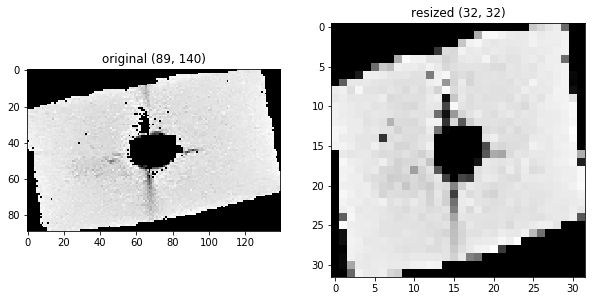

In [4]:
test_layer = data[:,:,25]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10,10))

ax1.imshow(test_layer, cmap=plt.cm.gray)
ax1.set_title('original ' + str(test_layer.shape))

resized_layer = resize(test_layer, (32,32), mode='reflect', anti_aliasing=False)

ax2.imshow(resized_layer, cmap=plt.cm.gray)
ax2.set_title('resized ' + str(resized_layer.shape))

plt.show()

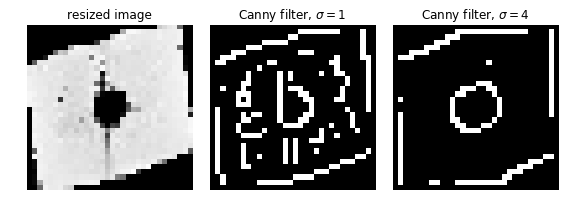

In [5]:
# Compute the Canny filter for two values of sigma
test_layer_resized = resize(test_layer, (32,32), mode='reflect', anti_aliasing=False)
edges1 = feature.canny(test_layer_resized, sigma=1)
edges2 = feature.canny(test_layer_resized, sigma=4)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(test_layer_resized, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('resized image')

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$')

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=4$')

fig.tight_layout()

plt.show()

In [6]:
data32 = resize(data, (32,32,32), mode='reflect', anti_aliasing=False)
edges_array = np.zeros((32,32,32))
sigma = 4
for i in range(data32.shape[2]):
    edges_array[i,:,:] += feature.canny(data32[i,:,:], sigma=sigma)
    edges_array[:,i,:] += feature.canny(data32[:,i,:], sigma=sigma)
    edges_array[:,:,i] += feature.canny(data32[:,:,i], sigma=sigma)
edges_array /= 3

nrows: 4, ncols: 8, nslices: 32


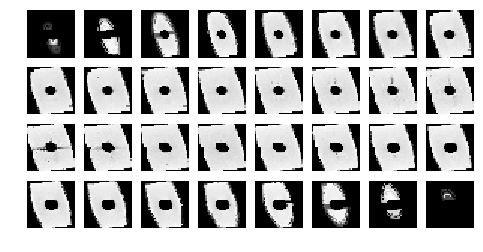

nrows: 4, ncols: 8, nslices: 32


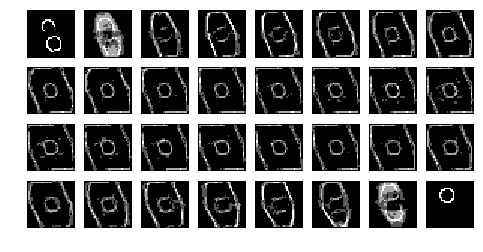

In [7]:
dim = 2
plot_dim(data32, dim=dim)
plot_dim(edges_array, dim=dim)

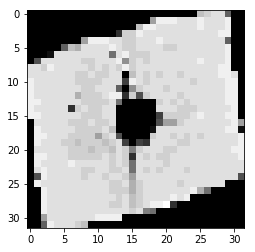

In [9]:
def quantize_image(data, n_levels):
    steps = np.max(data) / n_levels
    return (data / steps).astype(int)
Ng = 16
I = quantize_image(test_layer_resized, Ng)
plt.imshow(I,cmap=plt.cm.gray);plt.show()

In [16]:
def compute_glcm(I, Ng, dx, dy):
    '''gray level co-occurence matrix
    I: quantized image
    Ng: number of gray levels in quantized image
    https://en.wikipedia.org/wiki/Co-occurrence_matrix'''
    glcm = np.zeros((Ng,Ng))
    ix = itertools.product(range(Ng), range(Ng), range(I.shape[0]), range(I.shape[1]))
    for i, j, x, y in ix:
        try:
            if I[x,y] == i and I[x+dx,y+dy] == j:
                glcm[i,j] += 1
        except:
            pass
    return glcm + glcm.T

def compute_glcv(glcm, Ng):
    '''gray level co-occurence vector
    https://prism.ucalgary.ca/handle/1880/51900 page 24'''
    gldv = np.zeros((Ng))
    for i, j in itertools.product(range(Ng), range(Ng)):
        gldv[abs(i-j)] += glcm[i,j]
        
def compute_angular_2nd_moment(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 36'''
    a2m = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        a2m += glcm[i,j]**2
    return a2m

def compute_energy(glcm, Ng):
    '''https://prism.ucalgary.ca/handle/1880/51900 page 36'''
    return sqrt(compute_angular_2nd_moment)

def compute_contrast(glcm, Ng):
    contrast = 0
    for i, j in itertools.product(range(Ng),range(Ng)):
        contrast += abs(i-j)**2 * glcm[i,j]
    return contrast

In [17]:
horizontal_glcm = compute_glcm(I, Ng, 1, 0)
horizontal_gldv = compute_glcv(horizontal_glcm, Ng)
angular_2nd_moment = compute_angular_2nd_moment(horizontal_glcm, Ng)
energy = sqrt(angular_2nd_moment)
contrast = compute_contrast(horizontal_glcm, Ng)

In [20]:
angular_2nd_moment

759624.0